In [63]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

def parse_task_data(file_path):
    """
    解析单个info_infer_*.txt文件，提取任务信息和time_step_reward
    """
    with open(file_path, 'r') as f:
        content = f.read()
    
    # 提取任务信息 (第一行的tensor值)
    task_match = re.search(r'Task: tensor\(\[(.*?)\]', content)
    if task_match:
        task_values = [float(x.strip()) for x in task_match.group(1).split(',')]
        task_str = f"[{', '.join([f'{x:.1f}' for x in task_values])}]"
    else:
        task_str = "Unknown Task"
    
    # 提取time_step_reward
    reward_match = re.search(r'time_step_reward: ([\d\.-]+)', content)
    if reward_match:
        time_step_reward = float(reward_match.group(1))
    else:
        time_step_reward = 0.0
    
    return task_str, time_step_reward

def parse_task_data_with_action_rate(file_path):
    """
    解析单个info_infer_*.txt文件，提取任务信息、time_step_reward和action_rate
    """
    with open(file_path, 'r') as f:
        content = f.read()
    
    # 提取任务信息 (第一行的tensor值)
    task_match = re.search(r'Task: tensor\(\[(.*?)\]', content)
    if task_match:
        task_values = [float(x.strip()) for x in task_match.group(1).split(',')]
        task_str = f"[{', '.join([f'{x:.1f}' for x in task_values])}]"
    else:
        task_str = "Unknown Task"
    
    # 提取time_step_reward
    reward_match = re.search(r'time_step_reward: ([\d\.-]+)', content)
    if reward_match:
        time_step_reward = float(reward_match.group(1))
    else:
        time_step_reward = 0.0
    
    # 提取action_rate (寻找最后的 action_rate 值)
    action_rate_match = re.search(r'Reward \(action_rate\): ([\d\.-]+)', content)
    if action_rate_match:
        action_rate = float(action_rate_match.group(1))
    else:
        action_rate = 0.0
    
    return task_str, time_step_reward, action_rate

In [64]:
import ast

def normalize_task_string(task_str):
    """
    标准化任务字符串，将字符串解析为float列表再转换回标准化字符串
    """
    try:
        # 解析字符串为float列表
        float_list = ast.literal_eval(task_str)
        # 转换回标准化字符串格式（去除正号的影响）
        normalized_list = [float(x) for x in float_list]
        return str(normalized_list)
    except:
        # 如果解析失败，回退到原来的方法
        return task_str.replace(" ", "")

def find_matching_task(target_task, all_tasks):
    """
    在所有任务中找到与目标任务匹配的任务
    """
    target_normalized = normalize_task_string(target_task)
    
    for task in all_tasks:
        if normalize_task_string(task) == target_normalized:
            return task
    return None

def plot_task_comparison_grouped(folder_paths, labels, title="Task Performance Comparison", plot_sequence=None, figsize=(15, 8)):
    """
    按任务类型分组对比不同文件夹的结果
    同一类任务放在一块，不同文件夹用不同颜色，同一文件夹颜色保持一致
    
    Parameters:
    - folder_paths: list of str, 文件夹路径列表
    - labels: list of str, 对应的标签名称列表
    - title: str, 图表标题
    - figsize: tuple, 图表大小
    """
    
    if len(folder_paths) != len(labels):
        raise ValueError("folder_paths和labels的长度必须相同")
    
    # 收集所有数据
    all_folder_data = {}  # {folder_label: {task: reward}}
    all_tasks = set()     # 所有唯一的任务
    
    for folder_path, label in zip(folder_paths, labels):
        # 查找所有info_infer_*.txt文件
        pattern = os.path.join(folder_path, "**/info_infer_*.txt")
        info_files = glob.glob(pattern, recursive=True)
        
        if not info_files:
            print(f"警告: 在 {folder_path} 中没有找到info_infer_*.txt文件")
            continue
        
        folder_data = {}
        
        for file_path in info_files:
            try:
                task_str, reward = parse_task_data(file_path)
                folder_data[task_str] = reward
                all_tasks.add(task_str)
            except Exception as e:
                print(f"解析文件 {file_path} 时出错: {e}")
                continue
        
        if folder_data:
            all_folder_data[label] = folder_data
    
    if not all_folder_data:
        print("错误: 没有找到有效的数据")
        return
    
    # 按plot_sequence的顺序排序任务，使用兼容性匹配
    sorted_tasks = []
    matched_tasks = set()  # 记录已匹配的任务
    
    if plot_sequence is None:
        sorted_tasks = sorted(all_tasks)
    else:
        for seq_task in plot_sequence:
            matching_task = find_matching_task(seq_task, all_tasks)
            if matching_task and matching_task not in matched_tasks:
                sorted_tasks.append(matching_task)
                matched_tasks.add(matching_task)
    
        # 添加未在plot_sequence中的任务
        remaining_tasks = all_tasks - matched_tasks
        sorted_tasks.extend(sorted(remaining_tasks))

    # 设置颜色
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_folder_data)))
    
    # 创建图表
    plt.figure(figsize=figsize)
    
    # 计算柱子的宽度和位置
    n_folders = len(all_folder_data)
    bar_width = 0.8 / n_folders
    x_positions = np.arange(len(sorted_tasks))
    
    # 为每个文件夹绘制柱状图
    for i, (folder_label, folder_data) in enumerate(all_folder_data.items()):
        rewards = []
        for task in sorted_tasks:
            reward = folder_data.get(task, 0)  # 如果该任务不存在，设为0
            rewards.append(reward)
        
        # 计算每个柱子的x位置
        x_pos = x_positions + (i - n_folders/2 + 0.5) * bar_width
        
        # 绘制柱状图
        bars = plt.bar(x_pos, rewards, width=bar_width, label=folder_label, 
                      color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # 在柱子上标注数值
        for bar, reward in zip(bars, rewards):
            if reward > 0:  # 只在有数据的柱子上标注
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rewards)*0.01, 
                        f'{reward:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 设置图表
    plt.xlabel('Tasks')
    plt.ylabel('Time Step Reward')
    plt.title(title)
    plt.xticks(x_positions, sorted_tasks, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    # 画第二副图：统计每个 folder_path 下的平均任务奖励
    plt.figure(figsize=(10, 6))
    
    folder_avg_rewards = []
    folder_names = []
    
    for folder_label, folder_data in all_folder_data.items():
        if folder_data:  # 确保有数据
            avg_reward = np.mean(list(folder_data.values()))
            folder_avg_rewards.append(avg_reward)
            folder_names.append(folder_label)
    
    # 创建柱状图
    bars = plt.bar(range(len(folder_names)), folder_avg_rewards, 
                   color=colors[:len(folder_names)], alpha=0.8, 
                   edgecolor='black', linewidth=0.5)
    
    # 在柱子上标注数值
    for bar, avg_reward in zip(bars, folder_avg_rewards):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(folder_avg_rewards)*0.01, 
                f'{avg_reward:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.xlabel('Folder/Method')
    plt.ylabel('Average Task Reward')
    plt.title('Average Task Performance Comparison')
    plt.xticks(range(len(folder_names)), folder_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n=== 平均任务奖励统计 ===")
    for name, avg_reward in zip(folder_names, folder_avg_rewards):
        print(f"{name}: {avg_reward:.4f}")

In [65]:
def plot_action_rate_comparison_grouped(folder_paths, labels, title="Task Action Rate Comparison", plot_sequence=None, figsize=(15, 8)):
    """
    按任务类型分组对比不同文件夹的action rate结果
    同一类任务放在一块，不同文件夹用不同颜色，同一文件夹颜色保持一致
    
    Parameters:
    - folder_paths: list of str, 文件夹路径列表
    - labels: list of str, 对应的标签名称列表
    - title: str, 图表标题
    - figsize: tuple, 图表大小
    """
    
    if len(folder_paths) != len(labels):
        raise ValueError("folder_paths和labels的长度必须相同")
    
    # 收集所有数据
    all_folder_data = {}  # {folder_label: {task: action_rate}}
    all_tasks = set()     # 所有唯一的任务
    
    for folder_path, label in zip(folder_paths, labels):
        # 查找所有info_infer_*.txt文件
        pattern = os.path.join(folder_path, "**/info_infer_*.txt")
        info_files = glob.glob(pattern, recursive=True)
        
        if not info_files:
            print(f"警告: 在 {folder_path} 中没有找到info_infer_*.txt文件")
            continue
        
        folder_data = {}
        
        for file_path in info_files:
            try:
                task_str, _, action_rate = parse_task_data_with_action_rate(file_path)
                folder_data[task_str] = action_rate
                all_tasks.add(task_str)
            except Exception as e:
                print(f"解析文件 {file_path} 时出错: {e}")
                continue
        
        if folder_data:
            all_folder_data[label] = folder_data
    
    if not all_folder_data:
        print("错误: 没有找到有效的数据")
        return
    
    # 按plot_sequence的顺序排序任务，没有在plot_sequence中的任务排在最后
    sorted_tasks = []
    for task in plot_sequence:
        if task in all_tasks:
            sorted_tasks.append(task)
    
    # 添加不在plot_sequence中的任务
    remaining_tasks = sorted([task for task in all_tasks if task not in plot_sequence])
    sorted_tasks.extend(remaining_tasks)
    
    # 设置颜色
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_folder_data)))
    
    # 创建图表
    plt.figure(figsize=figsize)
    
    # 计算柱子的宽度和位置
    n_folders = len(all_folder_data)
    bar_width = 0.8 / n_folders
    x_positions = np.arange(len(sorted_tasks))
    
    # 为每个文件夹绘制柱状图
    for i, (folder_label, folder_data) in enumerate(all_folder_data.items()):
        action_rates = []
        for task in sorted_tasks:
            action_rate = folder_data.get(task, 0)  # 如果该任务不存在，设为0
            action_rates.append(action_rate)
        
        # 计算每个柱子的x位置
        x_pos = x_positions + (i - n_folders/2 + 0.5) * bar_width
        
        # 绘制柱状图
        bars = plt.bar(x_pos, action_rates, width=bar_width, label=folder_label, 
                      color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # 在柱子上标注数值
        for bar, action_rate in zip(bars, action_rates):
            if action_rate > 0:  # 只在有数据的柱子上标注
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(action_rates)*0.01, 
                        f'{action_rate:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 设置图表
    plt.xlabel('Tasks')
    plt.ylabel('Action Rate')
    plt.title(title)
    plt.xticks(x_positions, sorted_tasks, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    # 画第二副图：统计每个 folder_path 下的平均action rate
    plt.figure(figsize=(10, 6))
    
    folder_avg_action_rates = []
    folder_names = []
    
    for folder_label, folder_data in all_folder_data.items():
        if folder_data:  # 确保有数据
            avg_action_rate = np.mean(list(folder_data.values()))
            folder_avg_action_rates.append(avg_action_rate)
            folder_names.append(folder_label)
    
    # 创建柱状图
    bars = plt.bar(range(len(folder_names)), folder_avg_action_rates, 
                   color=colors[:len(folder_names)], alpha=0.8, 
                   edgecolor='black', linewidth=0.5)
    
    # 在柱子上标注数值
    for bar, avg_action_rate in zip(bars, folder_avg_action_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(folder_avg_action_rates)*0.01, 
                f'{avg_action_rate:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.xlabel('Folder/Method')
    plt.ylabel('Average Action Rate')
    plt.title('Average Action Rate Performance Comparison')
    plt.xticks(range(len(folder_names)), folder_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n=== 平均Action Rate统计 ===")
    for name, avg_action_rate in zip(folder_names, folder_avg_action_rates):
        print(f"{name}: {avg_action_rate:.6f}")

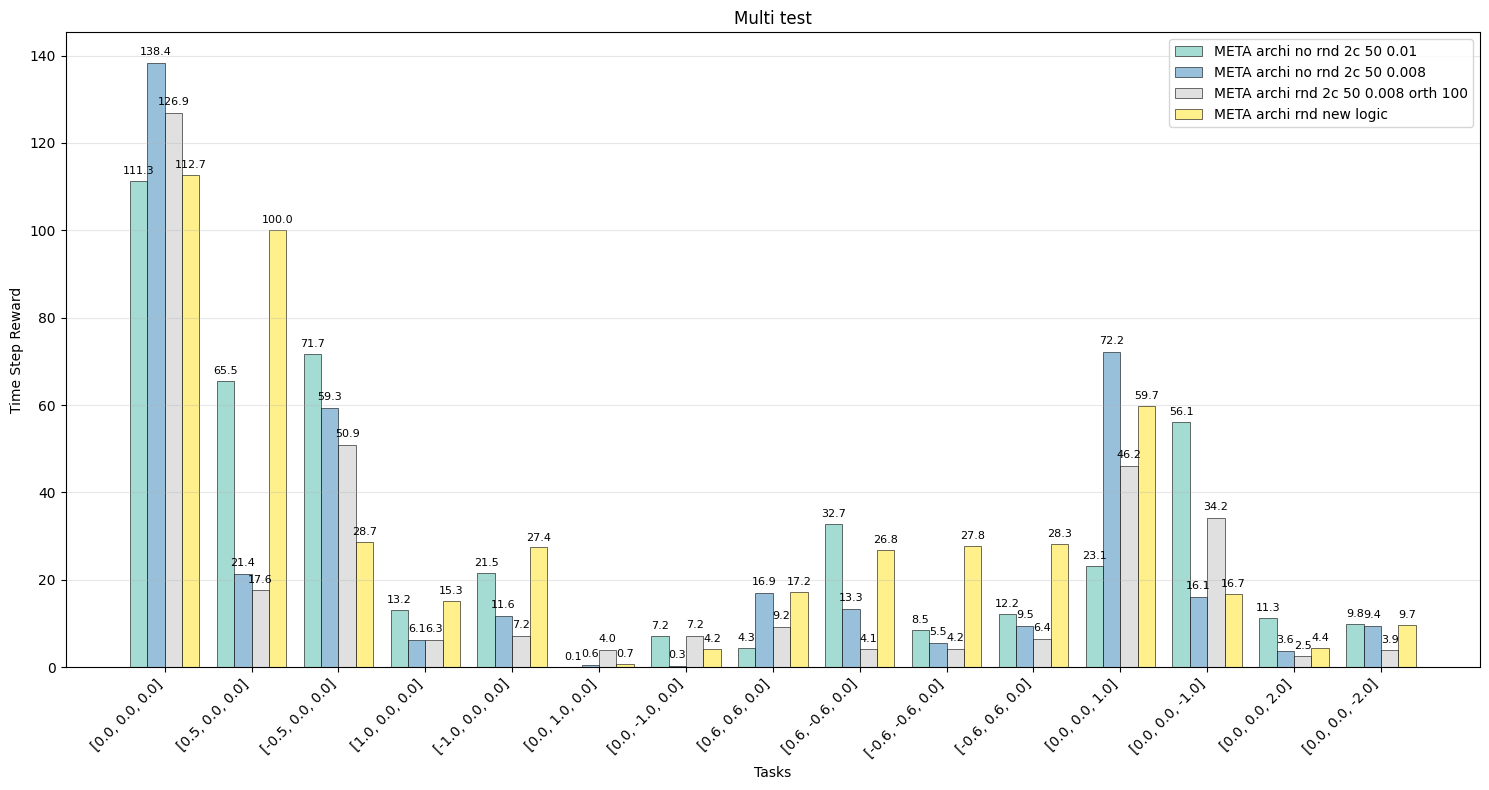

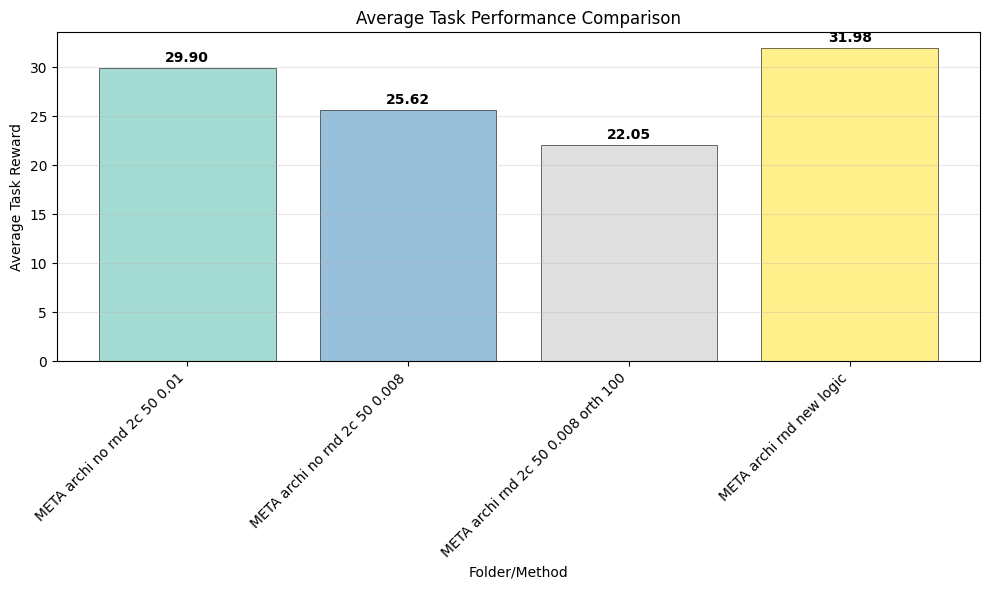


=== 平均任务奖励统计 ===
META archi no rnd 2c 50 0.01: 29.8977
META archi no rnd 2c 50 0.008: 25.6230
META archi rnd 2c 50 0.008 orth 100: 22.0503
META archi rnd new logic: 31.9834


In [69]:
plot_sequence = [
    "[0.0, 0.0, 0.0]",
    "[+0.5, 0.0, 0.0]",
    "[-0.5, 0.0, 0.0]",
    "[+1.0, 0.0, 0.0]",
    "[-1.0, 0.0, 0.0]",
    "[0.0, +1.0, 0.0]",
    "[0.0, -1.0, 0.0]",
    "[+0.6, +0.6, 0.0]",
    "[+0.6, -0.6, 0.0]",
    "[-0.6, -0.6, 0.0]",
    "[-0.6, +0.6, 0.0]",
    "[0.0, 0.0, +1.0]",
    "[0.0, 0.0, -1.0]",
    "[0.0, 0.0, +2.0]",
    "[0.0, 0.0, -2.0]",
]

# 示例：如果你有多个文件夹要对比
example_folders = [
    # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-11_12-21_Pretrain_1024_meta_FBA_q_infer_100k/09-11_13-41-48_collect_contact",
    # # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-15_12-09_Pretrain_1024_meta_FBA_no_q/09-15_14-21-47_collect_contact",
    # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-13_01-16_Pretrain_1024_10/09-13_19-06-01_collect_contact",
    # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-13_19-23_Pretrain_1024_5/09-13_20-54-27_collect_contact",
    # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-13_22-46_Pretrain_1024_2/09-14_12-03-58_collect_contact",
    # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-18_09-40_Pretrain_1024_meta_archi_q=0.1_(obs)/09-18_10-59-48_collect_contact",
    # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-18_11-21_Pretrain_1024_no_rnd_meta_archi_q=0.1/09-18_12-44-40_contact_collect_100",
    # "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-18_11-21_Pretrain_1024_no_rnd_meta_archi_q=0.1/09-18_12-47-44_contact_collect_50",
    "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-18_14-05_Pretrain_1024_no_rnd_meta_archi_2car_0.01/09-18_15-31-18_contact_collect",
    "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-18_23-49_Pretrain_1024_0.008_no_rnd_前进很好/09-19_10-27-14_contact_collect",
    "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-19_11-21_Pretrain_1024_0.008_rnd_orth=100_前进很差/09-19_12-48-16_contact_collect",
    "/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-24_14-24_Pretrain_1024_test_obs_logic/09-24_15-52-56_contact_collect",

]
example_labels = [
    # "META archi",
    # # "META archi no Q",
    # "META FB Contact coef = 10",
    # "META FB Contact coef = 5", 
    # "META FB Contact coef = 2", 
    # "META archi obs rnd f",
    # "META archi no rnd 100",
    # "META archi no rnd 50",
    "META archi no rnd 2c 50 0.01",
    "META archi no rnd 2c 50 0.008",
    "META archi rnd 2c 50 0.008 orth 100",
    "META archi rnd new logic"
    ]

# 如果只有一个文件夹，我们可以先测试数据解析
plot_task_comparison_grouped(example_folders, example_labels, "Multi test", plot_sequence=plot_sequence)

In [68]:
# # 使用新的函数画出每个task的action rate比较
# plot_action_rate_comparison_grouped(example_folders, example_labels, "Multi Action Rate Test")